# Recurrent Neural Networks (RNNs) Exploration: S&P 500 Stock Prices 

## Time-Series Forecasting

This Jupyter notebook uses Keras to build different neural network architectures including Recurrent Neureal Networks (RNNs) to explore different time-series forecasting for stock prices.

## Dataset

https://www.kaggle.com/camnugent/sandp500

## Objective

Explore the performances of different architectures applied to stock prices forecasting.

## Data Visualization

Import standard data handling and visualization libraries.

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sb

FACEBOOK_DATA_PATH = "FB_data.csv"
AMAZON_DATA_PATH = "AMZN_data.csv"
APPLE_DATA_PATH = "AAPL_data.csv"
NETFLIX_DATA_PATH = "NFLX_data.csv"
GOOGLE_DATA_PATH = "GOOGL_data.csv"

raw_fb_data = pd.read_csv(FACEBOOK_DATA_PATH)
raw_amzn_data = pd.read_csv(AMAZON_DATA_PATH)
raw_aapl_data = pd.read_csv(APPLE_DATA_PATH)
raw_nflx_data = pd.read_csv(NETFLIX_DATA_PATH)
raw_googl_data = pd.read_csv(GOOGLE_DATA_PATH)

Ensure the data sets do not have missing values.

In [2]:
print(f"Facebook Data Set Shape: {raw_fb_data.shape}, Missing Data: {raw_fb_data.isnull().values.any()}")
print(f"Amazon Data Set Shape: {raw_amzn_data.shape}, Missing Data: {raw_amzn_data.isnull().values.any()}")
print(f"Apple Data Set Shape: {raw_aapl_data.shape}, Missing Data: {raw_aapl_data.isnull().values.any()}")
print(f"Netflix Data Set Shape: {raw_nflx_data.shape}, Missing Data: {raw_nflx_data.isnull().values.any()}")
print(f"Google Data Set Shape: {raw_googl_data.shape}, Missing Data: {raw_googl_data.isnull().values.any()}")

Facebook Data Set Shape: (1259, 7), Missing Data: False
Amazon Data Set Shape: (1259, 7), Missing Data: False
Apple Data Set Shape: (1259, 7), Missing Data: False
Netflix Data Set Shape: (1259, 7), Missing Data: False
Google Data Set Shape: (1259, 7), Missing Data: False


Let's take a look at the data which consists of 7 columns. 

In [3]:
# show only the Facebook data set
raw_fb_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,28.89,29.17,28.51,28.5450,37662614,FB
1,2013-02-11,28.61,28.68,28.04,28.2600,36979533,FB
2,2013-02-12,27.67,28.16,27.10,27.3700,93417215,FB
3,2013-02-13,27.36,28.32,27.31,27.9075,50100805,FB
4,2013-02-14,28.02,28.63,28.01,28.5000,35581045,FB


All the data sets should look like the code block output above. A standard visualization of stock prices time-series is through a candlestick representation with displays the open, high, and low prices as a function of time progression. Let's write a function to generate these plots.

In [4]:
# the following function takes a list of stock data sets and generates candlestick plots for each
# the function uses plotly candlestick
def candlestick_plot(stock_data: list):

  for data_set in stock_data:
    fig = go.Figure(data=[go.Candlestick(x=data_set["date"],
                          open=data_set["open"],
                          high=data_set["high"],
                          low=data_set["low"],
                          close=data_set["close"])]
                   )

    fig.update_layout(
        title=f"{data_set['Name'][0]} Stock Prices Time-Series",
        xaxis_title="Date",
        yaxis_title="Price ($USD)",
        xaxis_rangeslider_visible=False)

    fig.show()

faang_stocks = [raw_fb_data, raw_amzn_data, raw_aapl_data, raw_nflx_data, raw_googl_data]

candlestick_plot(faang_stocks)

## Univariate Time-Series

In this section, we will use different neural network architectures to forecast "open" stock prices. As there is only 1 variable ("open" price) associated with each time step, the following models perform univariate time-series forecasting. To narrow the scope of the analysis and reduce training time, only `GOOGL` stock will be considered.

## Univariate Time-Series: Data Preparation

Before the data is ready to be used, it needs to be properly scaled and transformed into arrays of appropriate diemensions. Let's first take a look at the raw unmodified data.

In [5]:
# take a look at the GOOGL data
raw_googl_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
1,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
3,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
4,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


Let's remove the metrics that are not relevant to this section (keep only "date" and "open").

In [6]:
univariate_googl_data = raw_googl_data["open"].values
# verify the ensuing data set is as expected
print(univariate_googl_data)

[ 390.4551  389.5892  391.2659 ... 1100.61   1033.98   1084.97  ]


Manually split the raw `GOOGL` dataset into train/val/test splits following ~ 80/20/20 

In [7]:
train_array = univariate_googl_data[:759].reshape(-1,1)
val_array = univariate_googl_data[759:1000].reshape(-1,1)
test_array = univariate_googl_data[1000:1259].reshape(-1,1)

Next, we need to scale the data for training. The minimum and maximum values used in the scaler should only consider the train data to avoid data leakage. We can ensure this by using fit_transform on the train array and using only transform on the val and test arrays.

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_array = scaler.fit_transform(train_array)
val_array = scaler.transform(val_array)
test_array = scaler.transform(test_array)

Next, define a function that generates time series data as follows:

1) Receives as input a pandas DataFrame containing time-series data

2) Receives as input a time inteval integer which denotes the length of time-series sequences to generate

3) Receives as input the total time steps in the dataset. In the case of `GOOGL` stock data, this denotes the number of data entries

4) The function returns a list of arrays. Each array represents a time series sequence with length denoted by time interval. For example, if time interval were chosen as 60 the function appends to a list arrays containing entries `[0-59], [1-60], [2,61]`, etc. In essence, the stock dataset will be partitioned into the maximum number of sequential arrays possible given the provided time interval.

In [9]:
def series_generator(data: np.array, time_interval: int, total_time_steps: int) -> np.array:

  X_time_series, y_time_series = [], []

  for time_step in range(time_interval, total_time_steps):
    X_time_series.append(data[time_step - time_interval:time_step, 0])
    y_time_series.append(data[time_step, 0])

  X_time_series, y_time_series = np.array(X_time_series), np.array(y_time_series)
  return X_time_series, y_time_series

Generate the train, val, and test sets using the function defined above. We will use a time interval of 60 time-steps.

In [10]:
X_train, y_train = series_generator(train_array, 60, len(train_array))
X_val, y_val = series_generator(val_array, 60, len(val_array))
X_test, y_test = series_generator(test_array, 60, len(test_array))

Next, reshape X_train, X_val, and X_test to the form (to feed into an RNN later):

`[batch size, time steps, dimension]`

In [11]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# verify the array dimensions are as expected
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (699, 60, 1)
y_train shape: (699,)


The data is now ready to be fed into a neural network.

#### Univariate Time-Series: Define Utility Functions

We will define 2 plotting functions to help analyze time-series predictions.

In [12]:
# define a function to plot time-series data and predicted values
def plot_time_series(time_series_data: np.array, time_steps: int, y_true: float, y_pred: float, time_series_idx: str):

  sb.set_theme()
  plt.rcParams['figure.figsize'] = [20, 8]

  plt.plot(time_series_data, ".-")
  plt.plot(time_steps, y_true, "go", label="True Price")
  plt.plot(time_steps, y_pred, "rx", label="Model Predicted Price")
  
  plt.xlabel("Time-Step")
  plt.ylabel("Transformed Open Price")
  plt.title(f"{time_series_idx} Google Stock Time-Series")
  plt.grid(True)
  plt.legend(fontsize=16)

# define a function to plot time-series neural network mean squared error (MSE) history
def training_plots(training_progress: dict, model_name: str):
    
    sb.set_theme()
    plt.rcParams['figure.figsize'] = [20, 8]
    
    plt.plot(training_progress["loss"], "g", label="Train Loss")
    plt.plot(training_progress["val_loss"], "b", label="Validation Loss")
    plt.title(f"{model_name} Mean Squared Error (MSE) Plot", fontsize=16)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(fontsize=16)

## Univariate Time-Series: Neural Network Architectures Exploration

The models evaluated in this section will include:

1) Fully connected network 

2) Simple RNN

3) Deep RNN

4) Deep RNN with LSTM Cells

Before training any model, let's first obtain a baseline metric: simply copy the last value of each time-series as the predicted price. Let's see the mean squared error (MSE) associated with this naive approach.

In [13]:
import tensorflow as tf

# the naive approach simply copies the last value in each time series
naive_y_pred = X_val[:, -1]
naive_mse = np.mean(tf.keras.losses.mean_squared_error(y_val, naive_y_pred))
print(naive_mse)

# store the naive mse in a dictionary for comparison later
architectures_mse = {"Naive": naive_mse}

0.018099380102800208


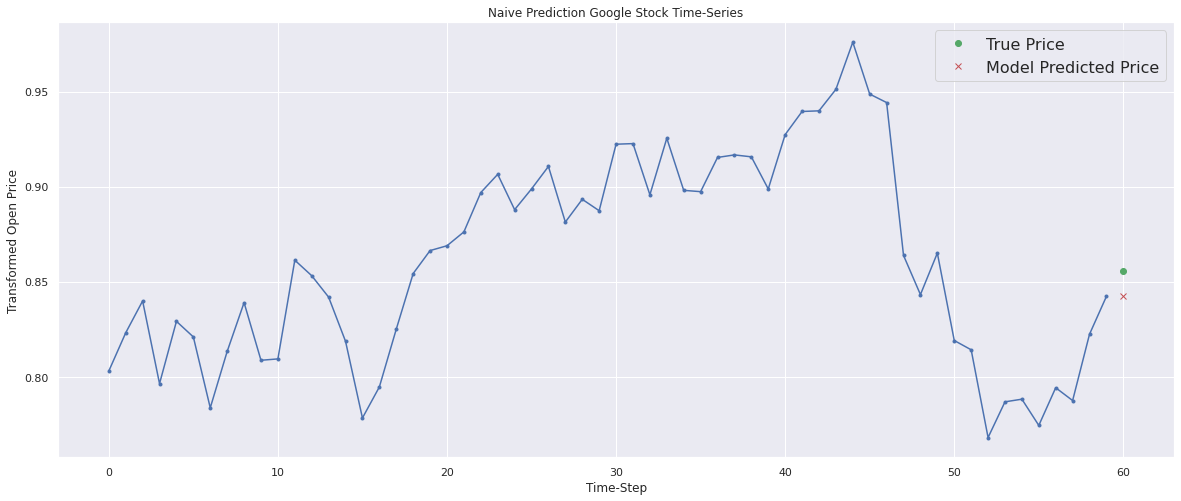

In [14]:
plot_time_series(X_val[0, :], 60, y_val[0], naive_y_pred[0], "Naive Prediction")

With a baseline metric computed, let's now build the first fully connected network architecture to perform Linear Regression.

#### Model 1: Simple Fully Connected Neural Network

In [15]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# define an early stopping callback, monitoring the mean squared error (MSE) validation set loss
val_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# define a performance scheduling callback, monitoring the mean squared error (MSE) validation set loss
lr_monitor = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# simply fully connected neural network
FCNN_model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=[60, 1]),
                tf.keras.layers.Dense(1)
             ])

# compile the model using standard settings
FCNN_model.compile(loss="mse",
                   optimizer="adam")

# display a of the model
FCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


Each time-step in a given series is represented by a single neuron and the overall architecture performins Linear Regression. Let's now train the model.

In [16]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
FCNN_history = FCNN_model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=64,
                              validation_data=(X_val, y_val),
                              callbacks=[val_stop, lr_monitor])

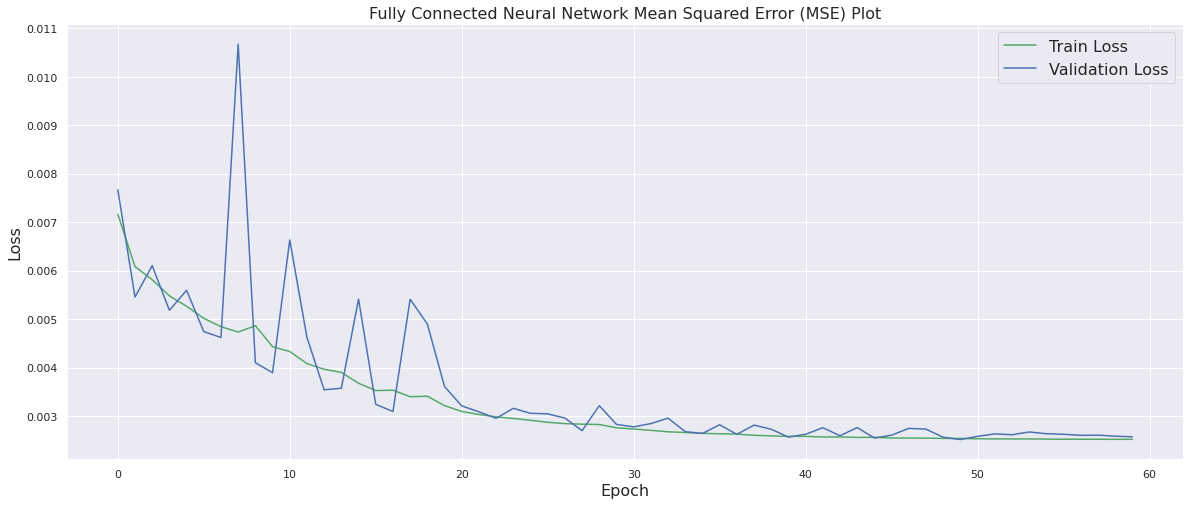

In [17]:
training_plots(FCNN_history.history, "Fully Connected Neural Network")

In [18]:
FCNN_mse = FCNN_model.evaluate(X_val, y_val, verbose=0)
print(f"Model Accuracy: {FCNN_mse}")

# store the FCNN mse in a dictionary for comparison later
architectures_mse["FCNN"] = FCNN_mse

FCNN_y_pred = FCNN_model.predict(X_val)

Model Accuracy: 0.002514724852517247


Show 4 predictions for time-series separated by 25 time-steps:

<Figure size 1440x576 with 0 Axes>

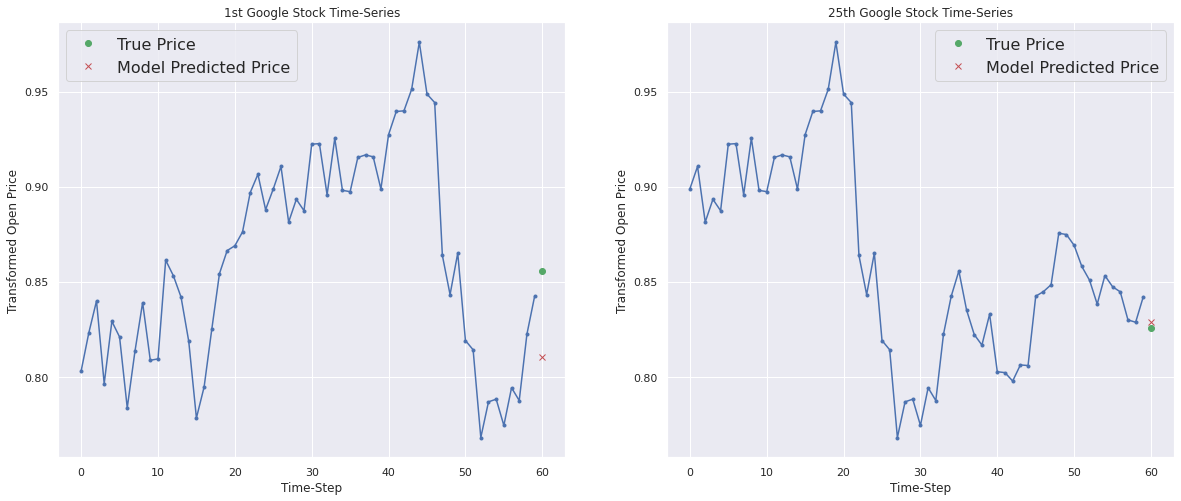

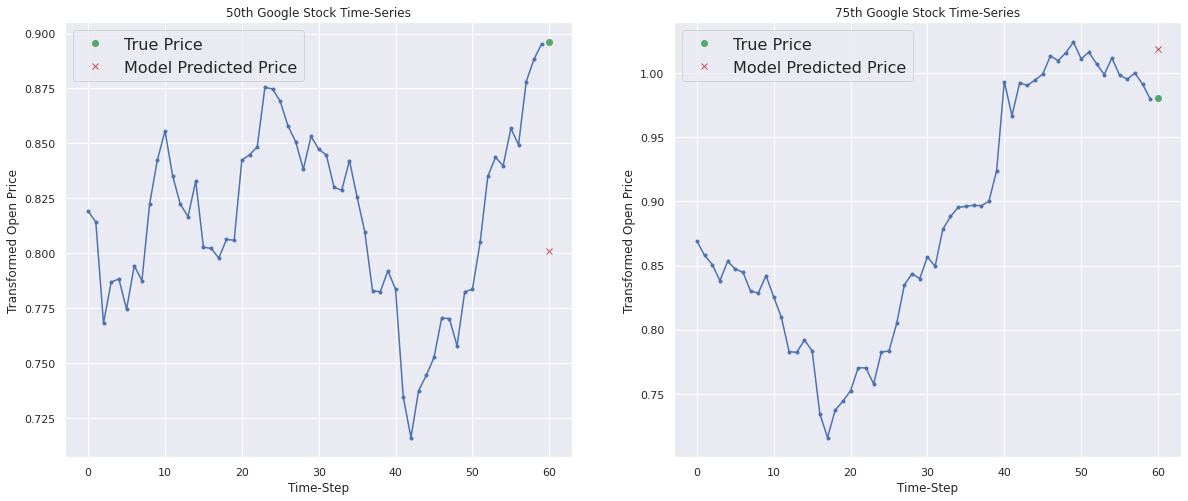

<Figure size 1440x576 with 0 Axes>

In [19]:
plt.subplot(1, 2, 1)
plot_time_series(X_val[0, :], 60, y_val[0], FCNN_y_pred[0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(X_val[25, :], 60, y_val[25], FCNN_y_pred[25], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(X_val[50, :], 60, y_val[50], FCNN_y_pred[50], "50th")
plt.subplot(1, 2, 2)
plot_time_series(X_val[75, :], 60, y_val[75], FCNN_y_pred[75], "75th")

plt.figure()

In [20]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247}


We observe that the fully connected neural network performs much better than the naive baseline approach. This is quantitatively supported by the lower MSE. Let's next try a simple RNN architecture.

#### Model 2: Simple Recurrent Neural Network (RNN)

Try a single neuron RNN.

In [21]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# single neuron RNN
single_neuron_RNN_model = tf.keras.models.Sequential([
                             tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
                          ])

# compile the model using standard settings
single_neuron_RNN_model.compile(loss="mse",
                                optimizer="adam")

# display a of the model
single_neuron_RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
single_neuron_RNN_history = single_neuron_RNN_model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=64,
                                                        validation_data=(X_val, y_val),
                                                        callbacks=[val_stop, lr_monitor])

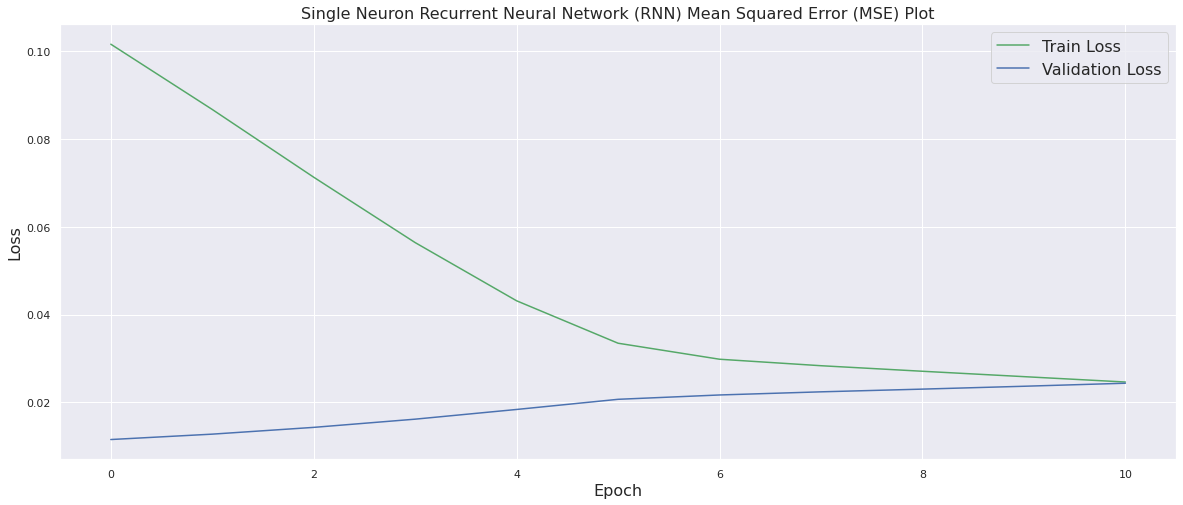

In [23]:
training_plots(single_neuron_RNN_history.history, "Single Neuron Recurrent Neural Network (RNN)")

In [24]:
single_neuron_RNN_mse = single_neuron_RNN_model.evaluate(X_val, y_val, verbose=0)
print(f"Model Accuracy: {single_neuron_RNN_mse}")

architectures_mse["Single Neuron RNN"] = single_neuron_RNN_mse

single_neuron_RNN_y_pred = single_neuron_RNN_model.predict(X_val)

Model Accuracy: 0.01150713674724102


Show 4 predictions for time-series separated by 25 time-steps:

<Figure size 1440x576 with 0 Axes>

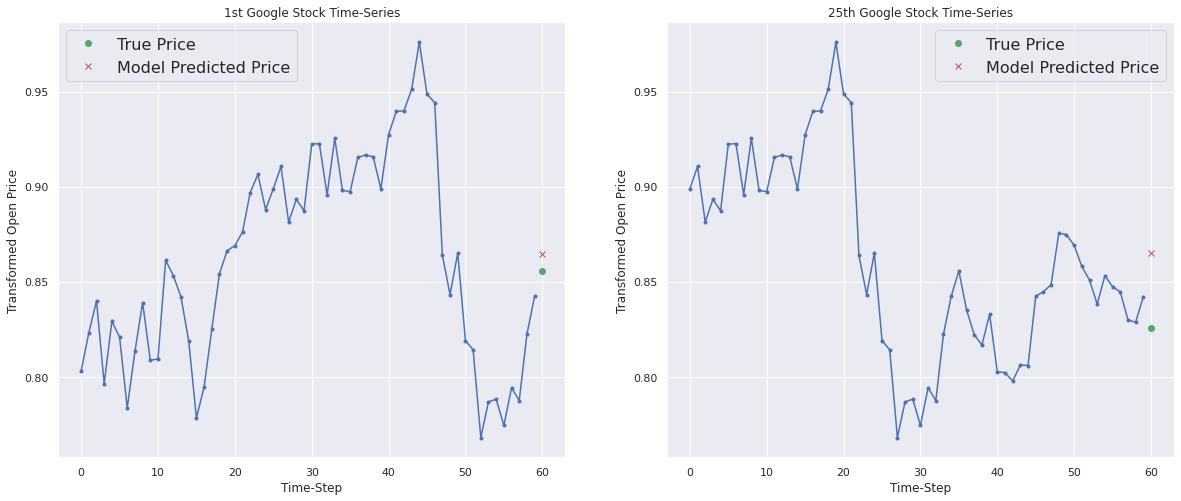

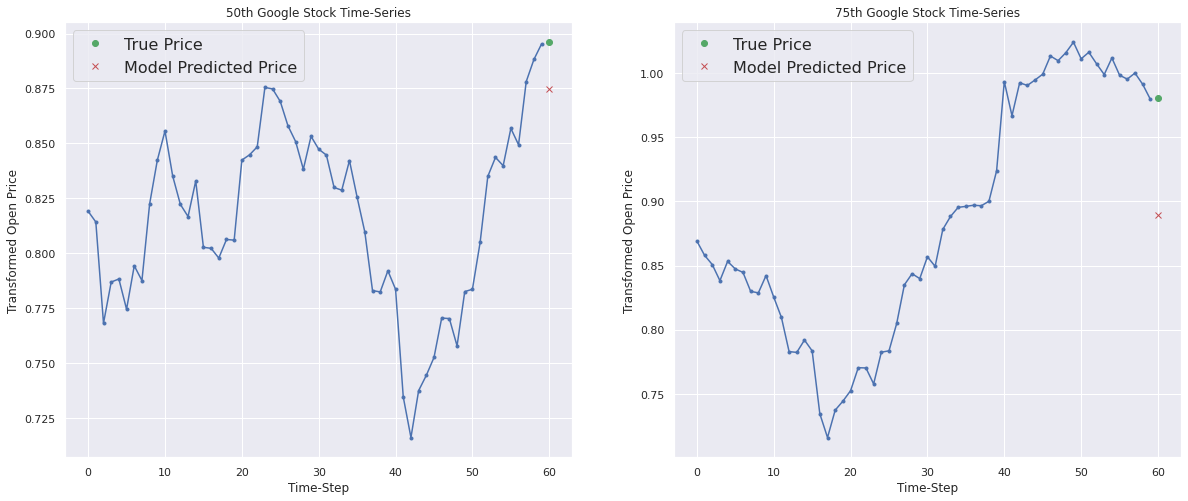

<Figure size 1440x576 with 0 Axes>

In [25]:
plt.subplot(1, 2, 1)
plot_time_series(X_val[0, :], 60, y_val[0], single_neuron_RNN_y_pred[0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(X_val[25, :], 60, y_val[25], single_neuron_RNN_y_pred[25], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(X_val[50, :], 60, y_val[50], single_neuron_RNN_y_pred[50], "50th")
plt.subplot(1, 2, 2)
plot_time_series(X_val[75, :], 60, y_val[75], single_neuron_RNN_y_pred[75], "75th")

plt.figure()

In [26]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102}


We observe that the single neuron RNN performs much worse than the fully connected neural network but better than the naive baseline approach. Let's next try a RNN with more hidden layers.

#### Model 3: Deep Recurrent Neural Network (RNN)

Dropout will be incorporated into the following RNN for regularization.

In [27]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# deep RNN
RNN_model = tf.keras.models.Sequential([
               tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 1]),
               tf.keras.layers.Dropout(0.2),
               tf.keras.layers.SimpleRNN(50, return_sequences=True),
               tf.keras.layers.Dropout(0.2),
               tf.keras.layers.SimpleRNN(50),
               tf.keras.layers.Dropout(0.2),
               tf.keras.layers.Dense(1)
             ])

# compile the model using standard settings
RNN_model.compile(loss="mse",
                   optimizer="adam")

# display a of the model
RNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 50)          2600      
_________________________________________________________________
dropout (Dropout)            (None, None, 50)          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 50)          5050      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [28]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
RNN_history = RNN_model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=64,
                            validation_data=(X_val, y_val),
                            callbacks=[val_stop, lr_monitor])

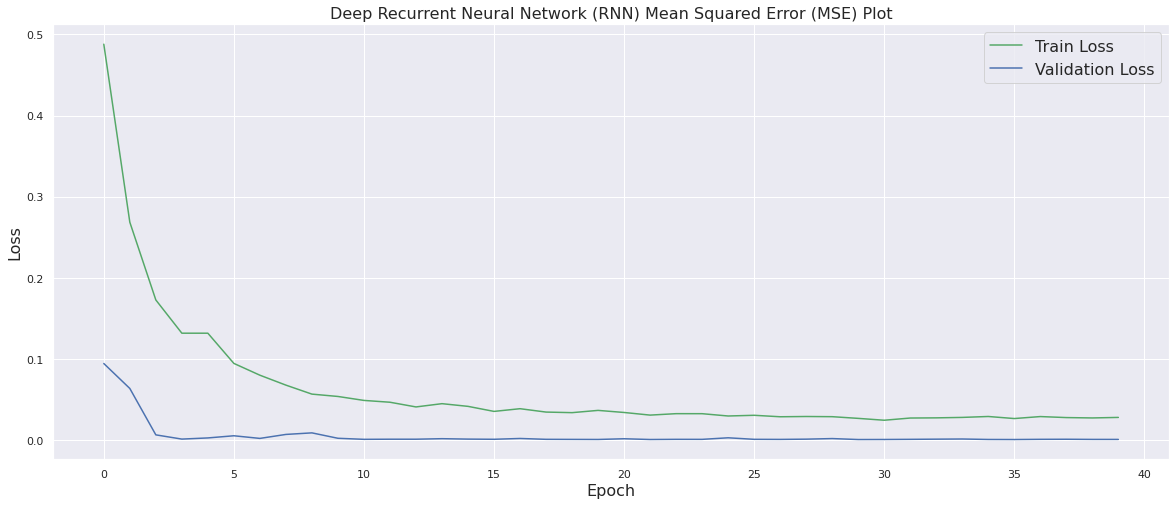

In [29]:
training_plots(RNN_history.history, "Deep Recurrent Neural Network (RNN)")

In [30]:
RNN_mse = RNN_model.evaluate(X_val, y_val, verbose=0)
print(f"Model Accuracy: {RNN_mse}")

architectures_mse["Deep RNN"] = RNN_mse

RNN_y_pred = RNN_model.predict(X_val)

Model Accuracy: 0.0007342133321799338


Show 4 predictions for time-series separated by 25 time-steps:

<Figure size 1440x576 with 0 Axes>

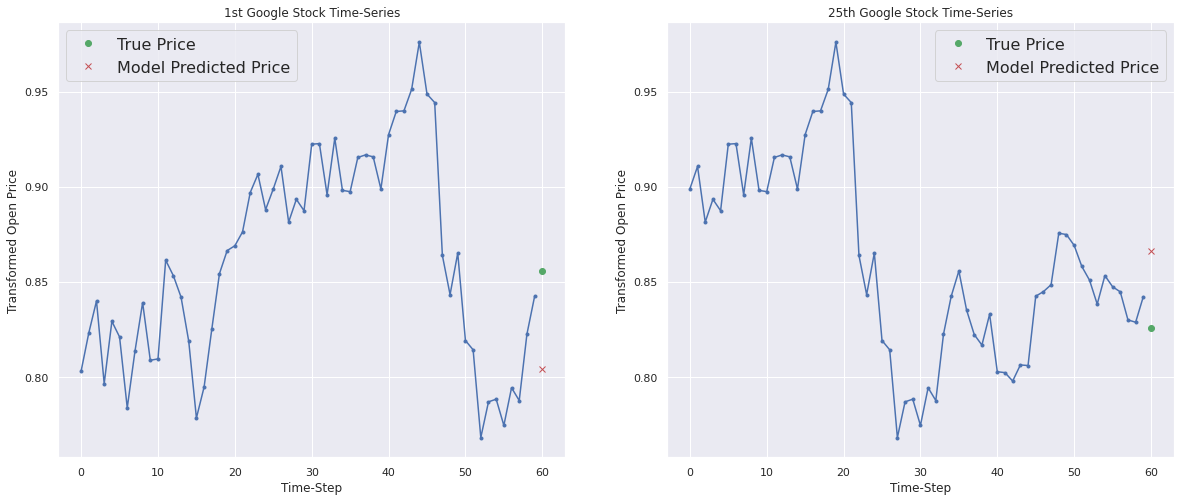

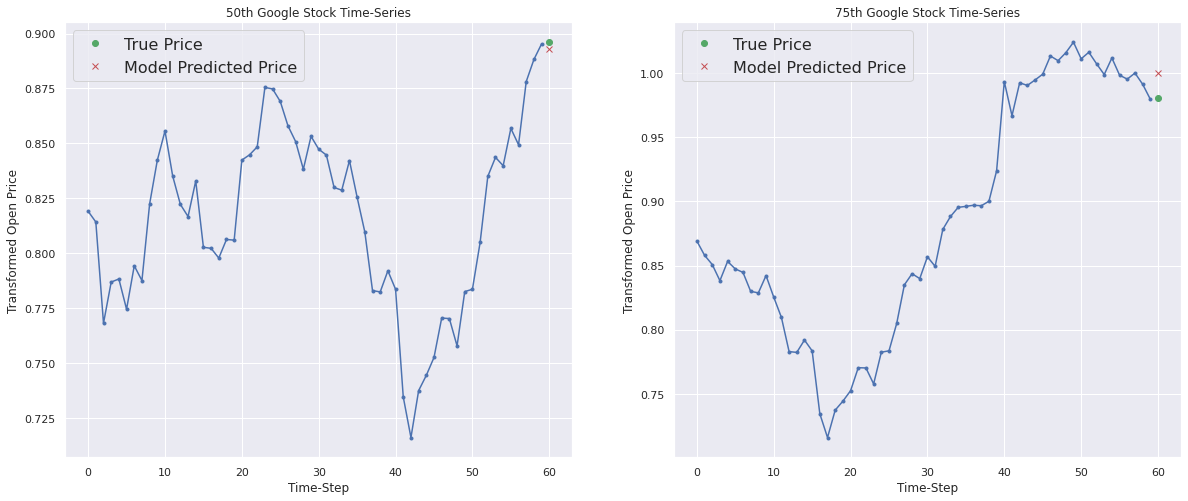

<Figure size 1440x576 with 0 Axes>

In [31]:
plt.subplot(1, 2, 1)
plot_time_series(X_val[0, :], 60, y_val[0], RNN_y_pred[0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(X_val[25, :], 60, y_val[25], RNN_y_pred[25], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(X_val[50, :], 60, y_val[50], RNN_y_pred[50], "50th")
plt.subplot(1, 2, 2)
plot_time_series(X_val[75, :], 60, y_val[75], RNN_y_pred[75], "75th")

plt.figure()

In [32]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338}


We observe that the deep RNN is now the best performing architecture. Finally, let's now try a RNN architecture which incorporates Long Short-Term Memory (LSTM) Cells.

#### Model 4: Deep Recurrent Neural Network (RNN) with Long Short-Term Memory Cells (LSTM)

Dropout will again be incorporated for regularization.

In [33]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# deep RNN
RNN_LSTM_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 1]),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.LSTM(50, return_sequences=True),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.LSTM(50),
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1)
                 ])

# compile the model using standard settings
RNN_LSTM_model.compile(loss="mse",
                       optimizer="adam")

# display a of the model
RNN_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 50)          10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [34]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
RNN_LSTM_history = RNN_LSTM_model.fit(X_train, y_train, epochs=1000, verbose=0, batch_size=64,
                                      validation_data=(X_val, y_val),
                                      callbacks=[val_stop, lr_monitor])

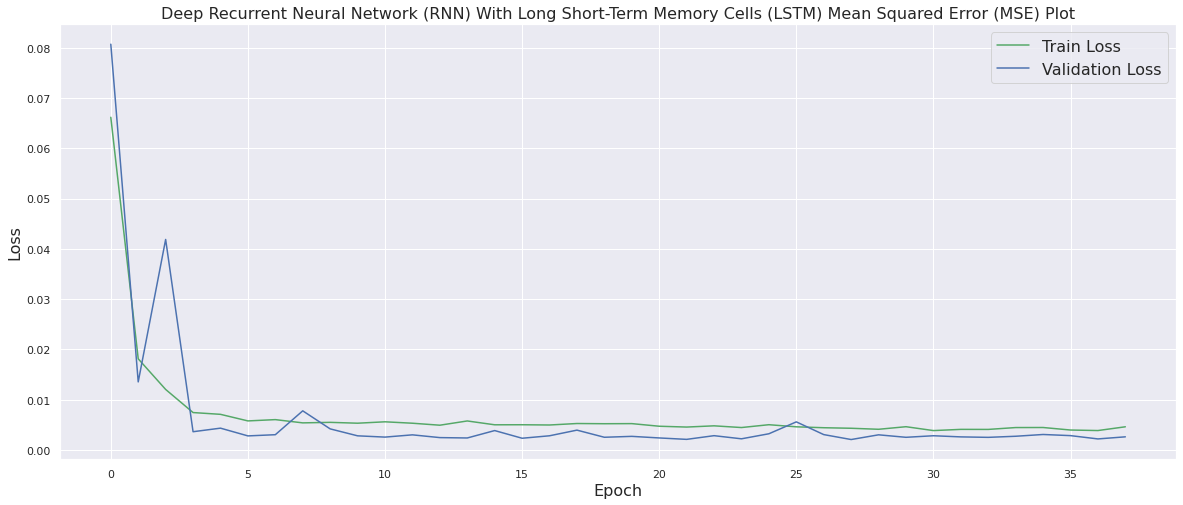

In [35]:
training_plots(RNN_LSTM_history.history, "Deep Recurrent Neural Network (RNN) With Long Short-Term Memory Cells (LSTM)")

In [36]:
RNN_LSTM_mse = RNN_LSTM_model.evaluate(X_val, y_val, verbose=0)
print(f"Model Accuracy: {RNN_LSTM_mse}")

architectures_mse["Deep LSTM RNN"] = RNN_LSTM_mse

RNN_LSTM_y_pred = RNN_LSTM_model.predict(X_val)

Model Accuracy: 0.0020811338908970356


Show 4 predictions for time-series separated by 25 time-steps:

<Figure size 1440x576 with 0 Axes>

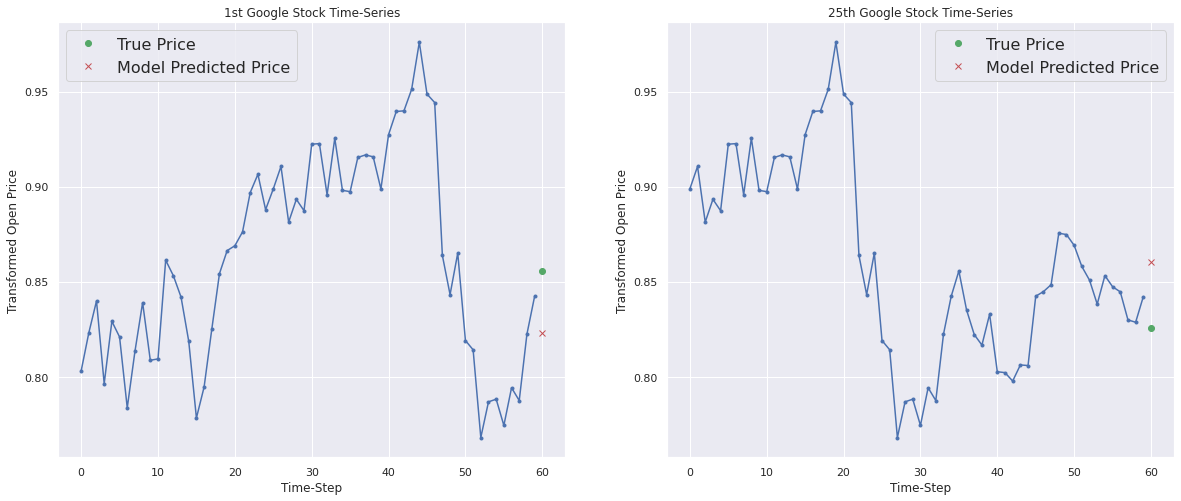

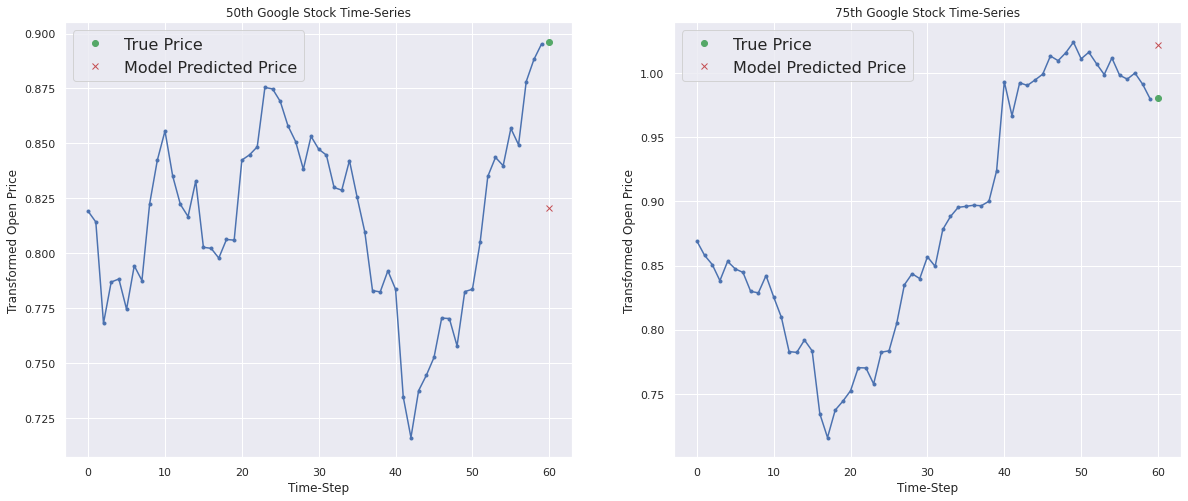

<Figure size 1440x576 with 0 Axes>

In [37]:
plt.subplot(1, 2, 1)
plot_time_series(X_val[0, :], 60, y_val[0], RNN_LSTM_y_pred[0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(X_val[25, :], 60, y_val[25], RNN_LSTM_y_pred[25], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(X_val[50, :], 60, y_val[50], RNN_LSTM_y_pred[50], "50th")
plt.subplot(1, 2, 2)
plot_time_series(X_val[75, :], 60, y_val[75], RNN_LSTM_y_pred[75], "75th")

plt.figure()

In [38]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338, 'Deep LSTM RNN': 0.0020811338908970356}


For the univariate time-series analysis, let's deploy the best model (Deep RNN) and measure it's performance on the test set.

In [39]:
RNN_test_mse = RNN_model.evaluate(X_test, y_test, verbose=0)
print(f"Deep RNN Validation Set MSE: {architectures_mse['Deep RNN']}")
print(f"Deep RNN Test Set MSE: {RNN_test_mse}")

print(RNN_LSTM_model.evaluate(X_train, y_train, verbose=0))

Deep RNN Validation Set MSE: 0.0007342133321799338
Deep RNN Test Set MSE: 0.03209763392806053
0.0026263867039233446


## Multivariate Time-Series

In this section, we will use only the RNN architectures as above to explore multivariate time-series analysis. Previously, only the "open" stock price was used to forecast the next "open" price. Other variables must also affect the "open" price such as "volume" traded. This section will use all the variables in the raw `GOOGL` stock data to predict "open" price.

## Multivariate Time-Series: Data Preparation

Before the data is ready to be used, it needs to be properly scaled and transformed into arrays of appropriate diemensions again. Let's take a look at the raw unmodified data again.

In [40]:
# take a look at the GOOGL data
raw_googl_data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,390.4551,393.7283,390.1698,393.0777,6031199,GOOGL
1,2013-02-11,389.5892,391.8915,387.2619,391.6012,4330781,GOOGL
2,2013-02-12,391.2659,394.3440,390.0747,390.7403,3714176,GOOGL
3,2013-02-13,390.4551,393.0677,390.3750,391.8214,2393946,GOOGL
4,2013-02-14,390.2549,394.7644,389.2739,394.3039,3466971,GOOGL


This time, all the other variables will be used to train our models. Drop the "date" and "Name" columns for simplicity.

In [41]:
multivariate_googl_data = raw_googl_data.drop(["date", "Name"], axis=1).values
print(multivariate_googl_data)

[[3.904551e+02 3.937283e+02 3.901698e+02 3.930777e+02 6.031199e+06]
 [3.895892e+02 3.918915e+02 3.872619e+02 3.916012e+02 4.330781e+06]
 [3.912659e+02 3.943440e+02 3.900747e+02 3.907403e+02 3.714176e+06]
 ...
 [1.100610e+03 1.114990e+03 1.056740e+03 1.062390e+03 4.177469e+06]
 [1.033980e+03 1.087380e+03 1.030010e+03 1.084430e+03 3.831524e+06]
 [1.084970e+03 1.086530e+03 1.054620e+03 1.055410e+03 2.597094e+06]]


In [42]:
train_array = multivariate_googl_data[:759]
val_array = multivariate_googl_data[759:1000]
test_array = multivariate_googl_data[1000:1259]
print(train_array.shape)

(759, 5)


In [43]:
multivariate_scaler = MinMaxScaler()
train_array = multivariate_scaler.fit_transform(train_array)
val_array = multivariate_scaler.transform(val_array)
test_array = multivariate_scaler.transform(test_array)

Define a modified function to generate the multivariate time-series data.


In [44]:
def multivariate_series_generator(data: np.array, time_interval: int, total_time_steps: int) -> np.array:

  X_time_series, y_time_series = [], []

  for time_step in range(time_interval, total_time_steps):
    X_time_series.append(data[time_step - time_interval:time_step, 0:data.shape[1]])
    y_time_series.append(data[time_step, 0:1])

  X_time_series, y_time_series = np.array(X_time_series), np.array(y_time_series)
  return X_time_series, y_time_series

In [45]:
# "mv" to denote multivariate
mv_X_train, mv_y_train = multivariate_series_generator(train_array, 60, len(train_array))
mv_X_val, mv_y_val = multivariate_series_generator(val_array, 60, len(val_array))
mv_X_test, mv_y_test = multivariate_series_generator(test_array, 60, len(test_array))

Verify the shapes of the arrays are correct. Recall the RNN array shape:

`[batch size, time steps, dimension]`

Dimension should be 5 now as there are 5 features.

In [46]:
print(mv_X_train.shape)

(699, 60, 5)


We are now ready to investigate the different model architectures. The naive baseline metric is the same as the previous case (where we simply copy the last value in a given time-series and take that as the predicted value for 1 day ahead). The naive baseline metric is the same in the current multivariate time-series analysis because we are still only prediction "open" price. The difference compared to the previous univariate time-series analysis is that we are now using all the other features (which we assume has an effect on "open" price) such as "volume" (volume traded).

#### Model 1: Simple Fully Connected Neural Network

Previously, univariate time-series analysis essentially used Linear Regression. Here, we are using Multiple Regression (we are using more than 1 variable ("close" price, "volume", etc.) to predict the output dependent variable ("open" price).

In [47]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# simply fully connected neural network
multivariate_FCNN_model = tf.keras.models.Sequential([
                             tf.keras.layers.Flatten(input_shape=[60, 5]),
                             tf.keras.layers.Dense(1)
                          ])

# compile the model using standard settings
multivariate_FCNN_model.compile(loss="mse",
                   optimizer="adam")

# display a of the model
multivariate_FCNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 301       
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [48]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
multivariate_FCNN_history = multivariate_FCNN_model.fit(mv_X_train, mv_y_train, epochs=1000, verbose=0, batch_size=64,
                                                        validation_data=(mv_X_val, mv_y_val),
                                                        callbacks=[val_stop, lr_monitor])

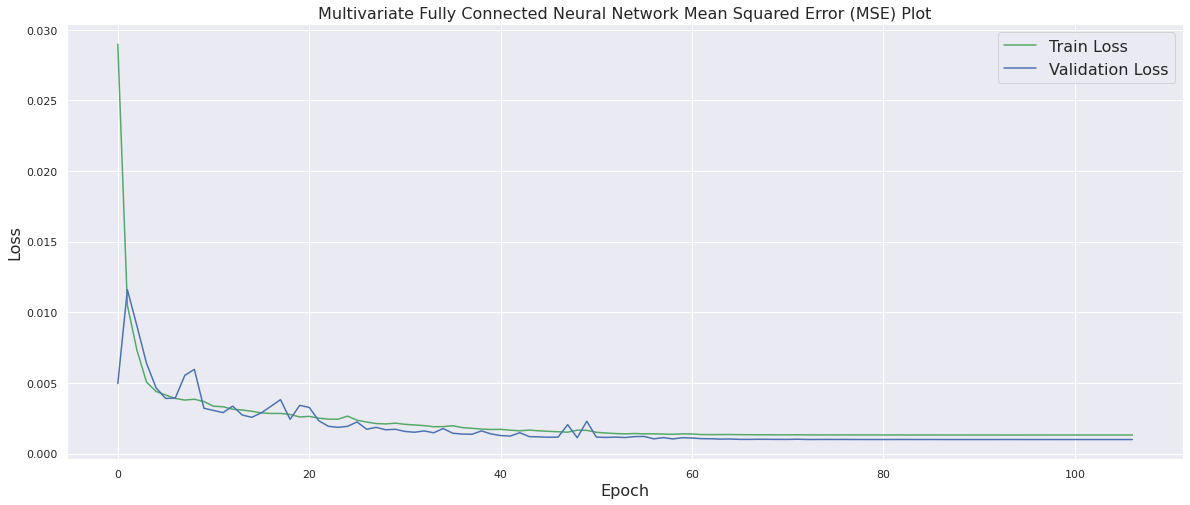

In [49]:
training_plots(multivariate_FCNN_history.history, "Multivariate Fully Connected Neural Network")

In [50]:
multivariate_FCNN_mse = multivariate_FCNN_model.evaluate(mv_X_val, mv_y_val, verbose=0)
print(f"Model Accuracy: {multivariate_FCNN_mse}")

# store the FCNN mse in a dictionary for comparison later
architectures_mse["MV FCNN"] = multivariate_FCNN_mse

multivariate_FCNN_y_pred = multivariate_FCNN_model.predict(mv_X_val)

Model Accuracy: 0.0009896964766085148


Show 4 predictions for time-series separated by 25 time-steps:

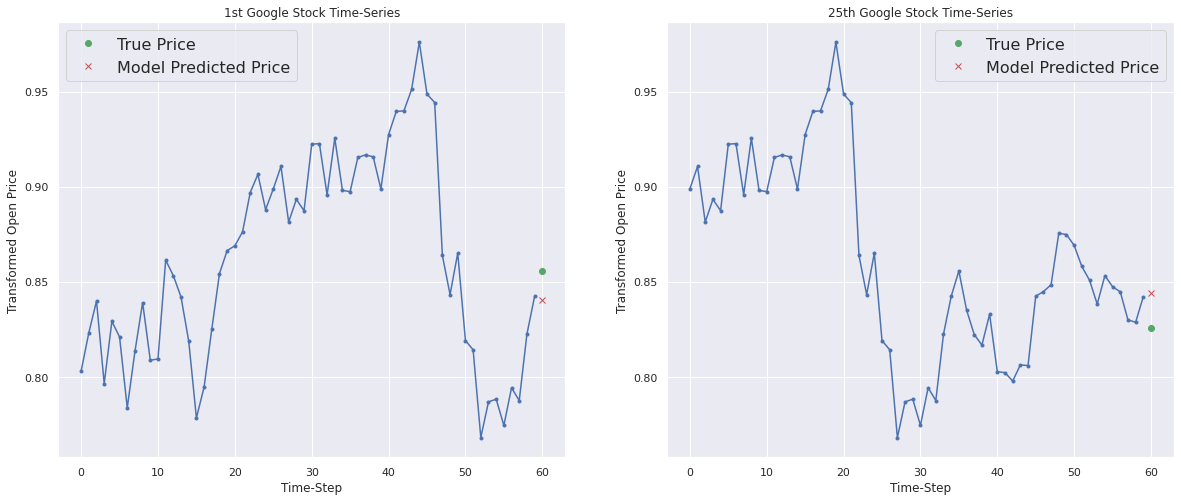

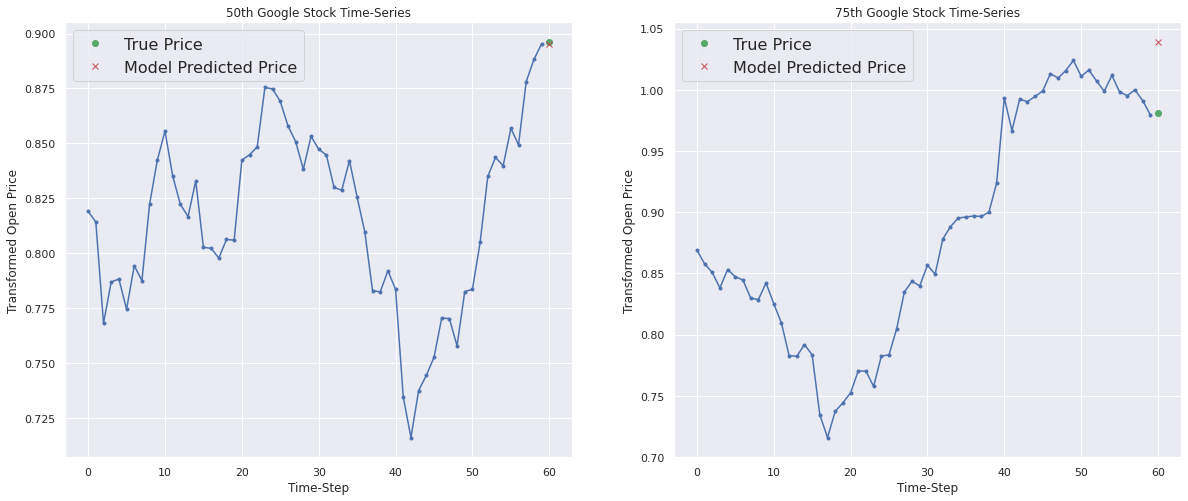

In [51]:
plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[0][:, 0], 60, mv_y_val[0], multivariate_FCNN_y_pred[0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[25][:, 0], 60, mv_y_val[25], multivariate_FCNN_y_pred[25], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[50][:, 0], 60, mv_y_val[50], multivariate_FCNN_y_pred[50], "50th")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[75][:, 0], 60, mv_y_val[75], multivariate_FCNN_y_pred[75], "75th")

In [52]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338, 'Deep LSTM RNN': 0.0020811338908970356, 'MV FCNN': 0.0009896964766085148}


The Multiple Regression neural network performs very well! Just behind the deep RNN. This is most likely due to feeding in more data. Let's now investigate a single neuron RNN.

#### Model 2: Simple Recurrent Neural Network (RNN)

In [53]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# single neuron RNN
multivariate_single_neuron_RNN_model = tf.keras.models.Sequential([
                                          tf.keras.layers.SimpleRNN(1, input_shape=[None, 5])
                                       ])

# compile the model using standard settings
multivariate_single_neuron_RNN_model.compile(loss="mse",
                                             optimizer="adam")

# display a of the model
multivariate_single_neuron_RNN_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1)                 7         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [54]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
multivariate_single_neuron_RNN_history = multivariate_single_neuron_RNN_model.fit(mv_X_train, mv_y_train, epochs=1000, verbose=0, batch_size=64,
                                                                                  validation_data=(mv_X_val, mv_y_val),
                                                                                  callbacks=[val_stop, lr_monitor])

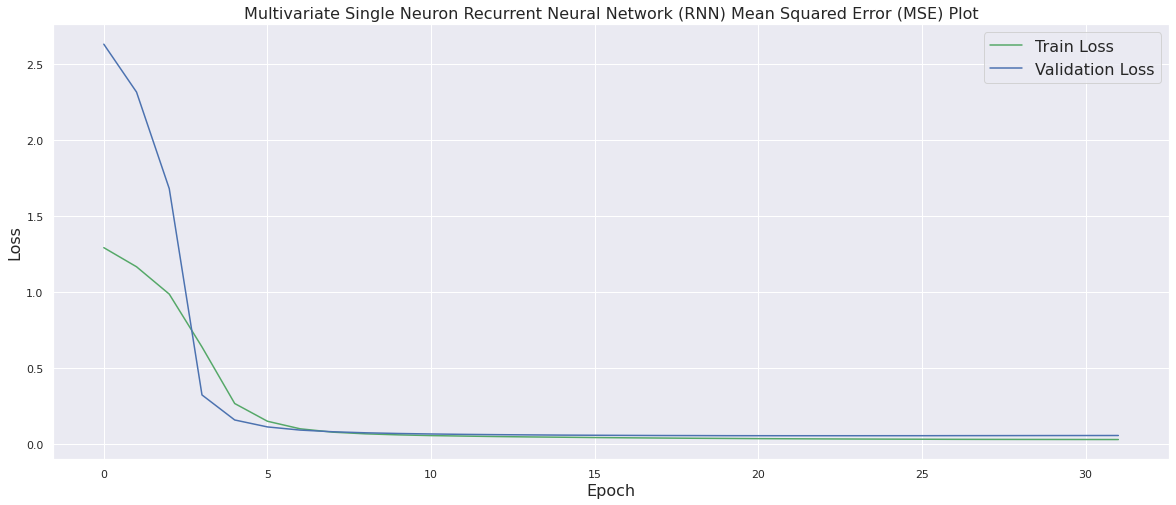

In [55]:
training_plots(multivariate_single_neuron_RNN_history.history, "Multivariate Single Neuron Recurrent Neural Network (RNN)")

In [56]:
multivariate_single_neuron_RNN_mse = multivariate_single_neuron_RNN_model.evaluate(mv_X_val, mv_y_val, verbose=0)
print(f"Model Accuracy: {multivariate_single_neuron_RNN_mse}")

architectures_mse["MV Single Neuron RNN"] = multivariate_single_neuron_RNN_mse

multivariate_single_neuron_RNN_y_pred = multivariate_single_neuron_RNN_model.predict(mv_X_val)

Model Accuracy: 0.0571771077811718


Show 4 predictions for time-series separated by 25 time-steps:

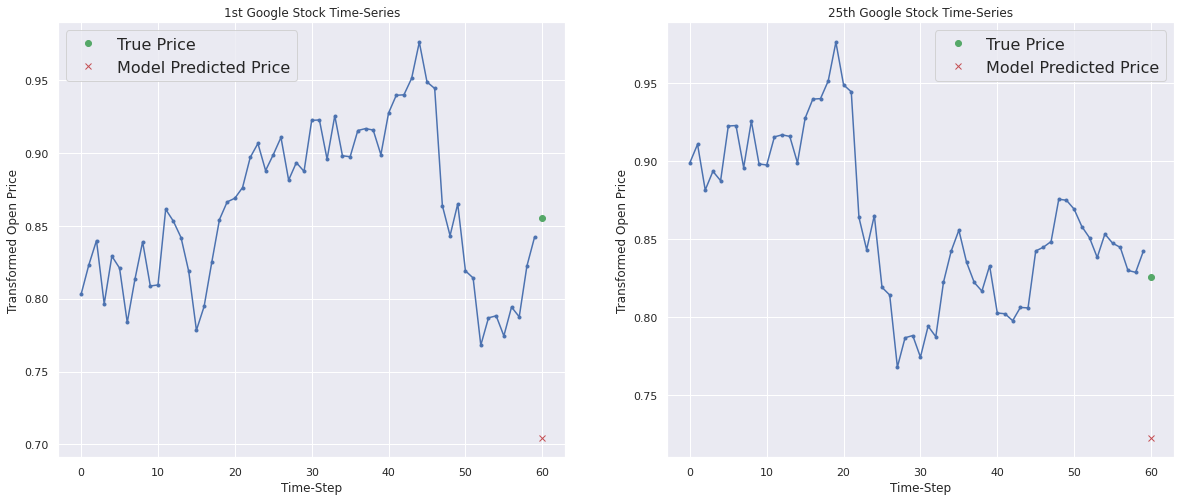

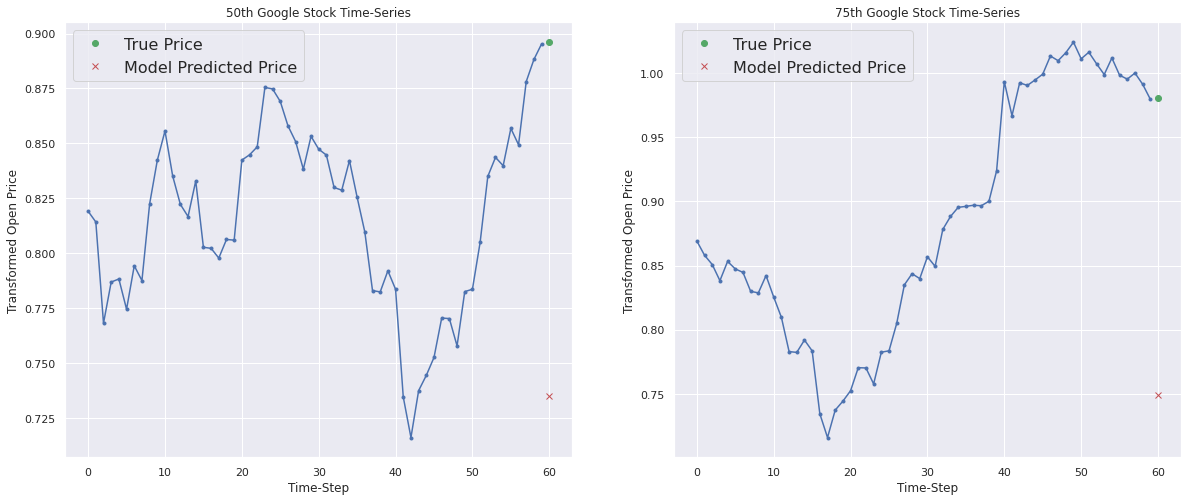

In [57]:
plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[0][:, 0], 60, mv_y_val[0], multivariate_single_neuron_RNN_y_pred[0][0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[25][:, 0], 60, mv_y_val[25], multivariate_single_neuron_RNN_y_pred[25][0], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[50][:, 0], 60, mv_y_val[50], multivariate_single_neuron_RNN_y_pred[50][0], "50th")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[75][:, 0], 60, mv_y_val[75], multivariate_single_neuron_RNN_y_pred[75][0], "75th")

In [58]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338, 'Deep LSTM RNN': 0.0020811338908970356, 'MV FCNN': 0.0009896964766085148, 'MV Single Neuron RNN': 0.0571771077811718}


The single neuron RNN perform by far the worst! Even worse than the naive approach. This is most likely due to an insufficient architecture to learn from the data. We are employing a single recurrent neuron to learn 5 different features. Let's now investigate a deep RNN.

#### Model 3: Deep Recurrent Neural Network (RNN)

Dropout will be incorporated into the following RNN for regularization.

In [59]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# deep RNN
multivariate_RNN_model = tf.keras.models.Sequential([
                            tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=[None, 5]),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.SimpleRNN(50, return_sequences=True),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.SimpleRNN(50),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(1)
                         ])

# compile the model using standard settings
multivariate_RNN_model.compile(loss="mse",
                               optimizer="adam")

# display a of the model
multivariate_RNN_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, None, 50)          2800      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, None, 50)          5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [60]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
multivariate_RNN_history = multivariate_RNN_model.fit(mv_X_train, mv_y_train, epochs=1000, verbose=0, batch_size=64,
                                                      validation_data=(mv_X_val, mv_y_val),
                                                      callbacks=[val_stop, lr_monitor])

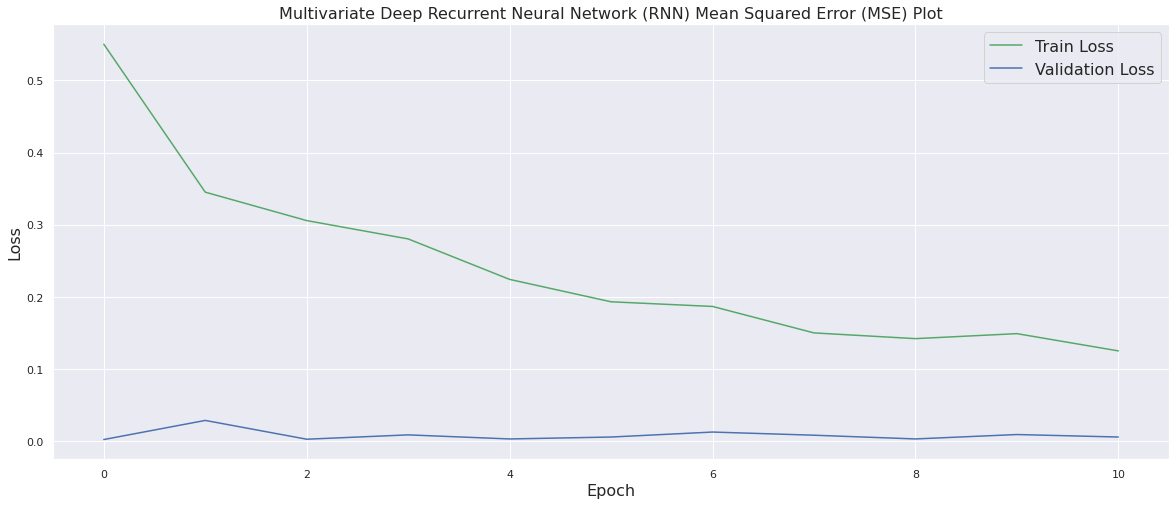

In [61]:
training_plots(multivariate_RNN_history.history, "Multivariate Deep Recurrent Neural Network (RNN)")

In [62]:
multivariate_RNN_mse = multivariate_RNN_model.evaluate(mv_X_val, mv_y_val, verbose=0)
print(f"Model Accuracy: {multivariate_RNN_mse}")

architectures_mse["MV Deep RNN"] = multivariate_RNN_mse

multivariate_RNN_y_pred = multivariate_RNN_model.predict(mv_X_val)

Model Accuracy: 0.0020461438689380884


Show 4 predictions for time-series separated by 25 time-steps:

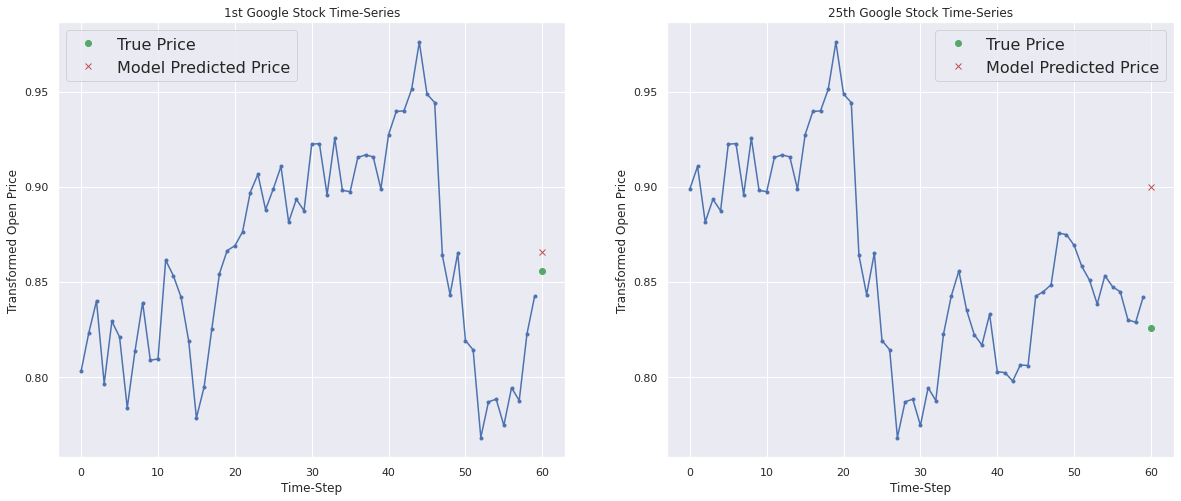

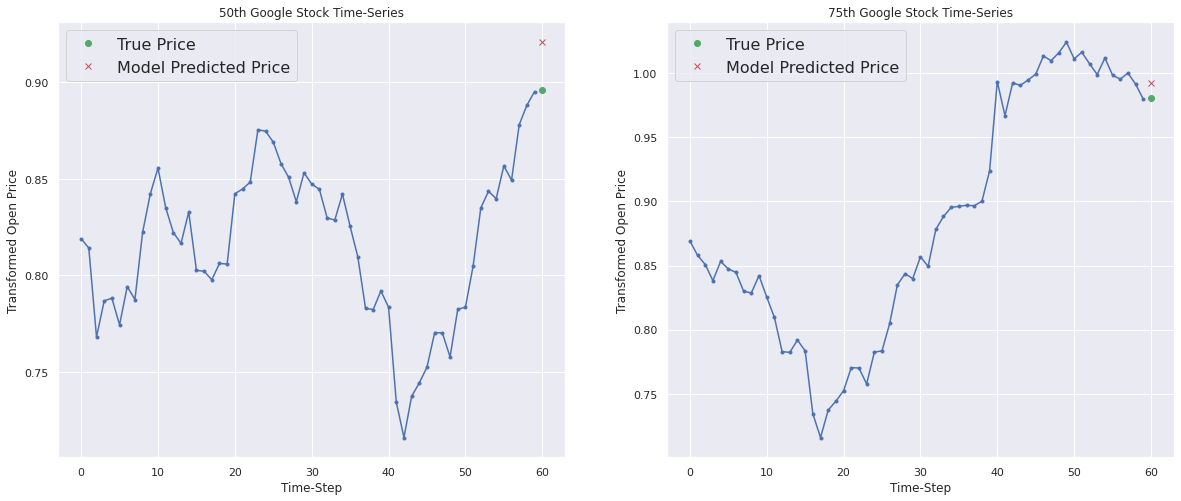

In [63]:
plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[0][:, 0], 60, mv_y_val[0], multivariate_RNN_y_pred[0][0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[25][:, 0], 60, mv_y_val[25], multivariate_RNN_y_pred[25][0], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[50][:, 0], 60, mv_y_val[50], multivariate_RNN_y_pred[50][0], "50th")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[75][:, 0], 60, mv_y_val[75], multivariate_RNN_y_pred[75][0], "75th")

In [64]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338, 'Deep LSTM RNN': 0.0020811338908970356, 'MV FCNN': 0.0009896964766085148, 'MV Single Neuron RNN': 0.0571771077811718, 'MV Deep RNN': 0.0020461438689380884}


The deep RNN performs much better than the single neuron RNN for multivariate time-series analysis but worse than the fully connected neural network. Let's 
investigate the deep RNN using LSTM cells.

#### Model 4: Deep Recurrent Neural Network (RNN) with Long Short-Term Memory Cells (LSTM)

Dropout will again be incorporated for regularization.

In [65]:
# set seeds to 42 for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# deep RNN
multivariate_RNN_LSTM_model = tf.keras.models.Sequential([
                              tf.keras.layers.LSTM(50, return_sequences=True, input_shape=[None, 5]),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.LSTM(50, return_sequences=True),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.LSTM(50),
                              tf.keras.layers.Dropout(0.2),
                              tf.keras.layers.Dense(1)
                              ])

# compile the model using standard settings
multivariate_RNN_LSTM_model.compile(loss="mse",
                                    optimizer="adam")

# display a of the model
multivariate_RNN_LSTM_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, None, 50)          11200     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 50)          20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 50)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [66]:
# train the model
# epochs is set to 1000 as callbacks are used to stop training
multivariate_RNN_LSTM_history = multivariate_RNN_LSTM_model.fit(mv_X_train, mv_y_train, epochs=1000, verbose=0, batch_size=64,
                                                                validation_data=(mv_X_val, mv_y_val),
                                                                callbacks=[val_stop, lr_monitor])

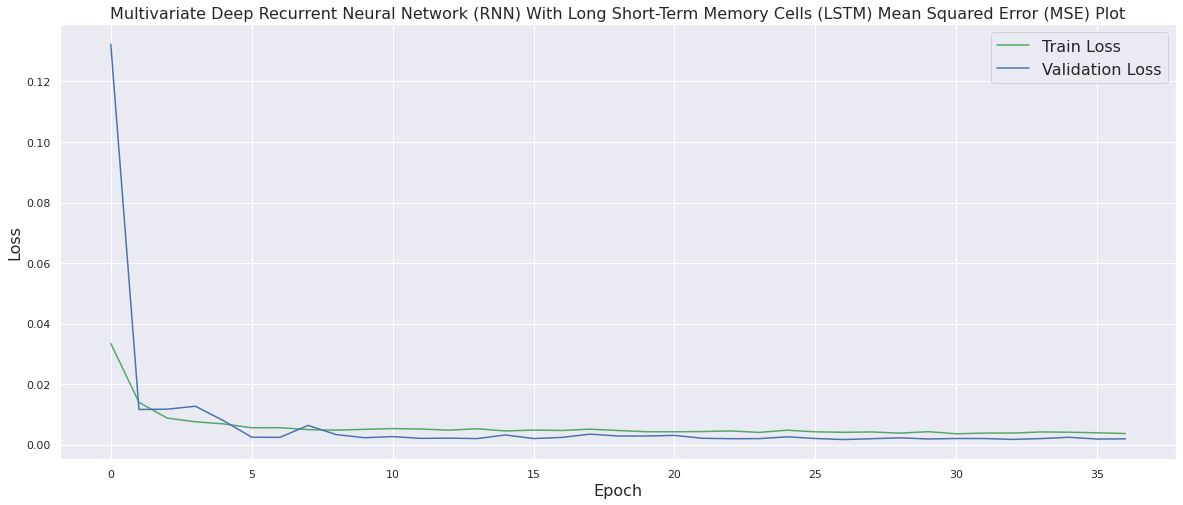

In [67]:
training_plots(multivariate_RNN_LSTM_history.history, "Multivariate Deep Recurrent Neural Network (RNN) With Long Short-Term Memory Cells (LSTM)")

In [68]:
multivariate_RNN_LSTM_mse = multivariate_RNN_LSTM_model.evaluate(mv_X_val, mv_y_val, verbose=0)
print(f"Model Accuracy: {multivariate_RNN_LSTM_mse}")

architectures_mse["MV Deep LSTM RNN"] = multivariate_RNN_LSTM_mse

multivariate_RNN_LSTM_y_pred = multivariate_RNN_LSTM_model.predict(mv_X_val)

Model Accuracy: 0.0016605647979304194


Show 4 predictions for time-series separated by 25 time-steps:

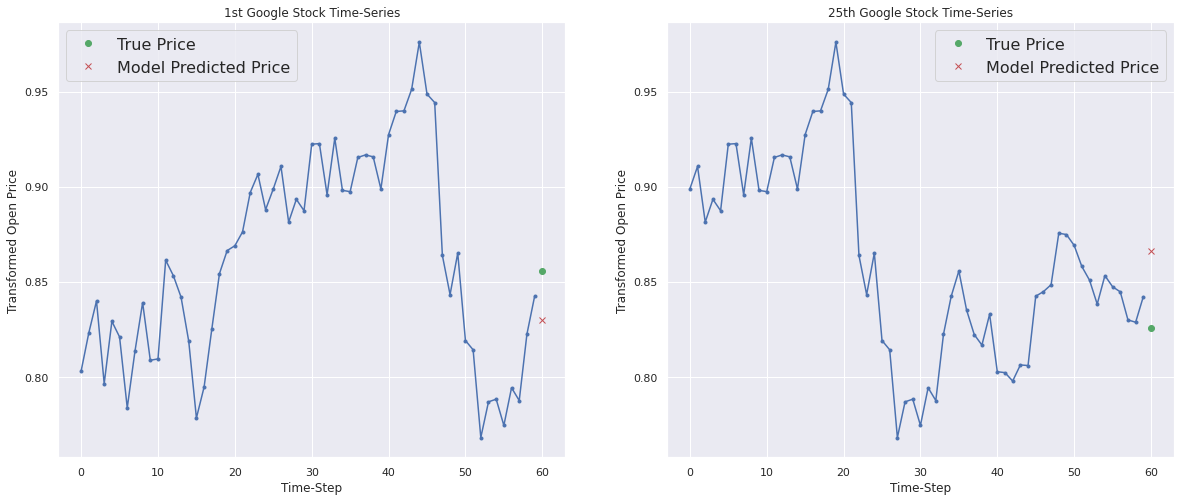

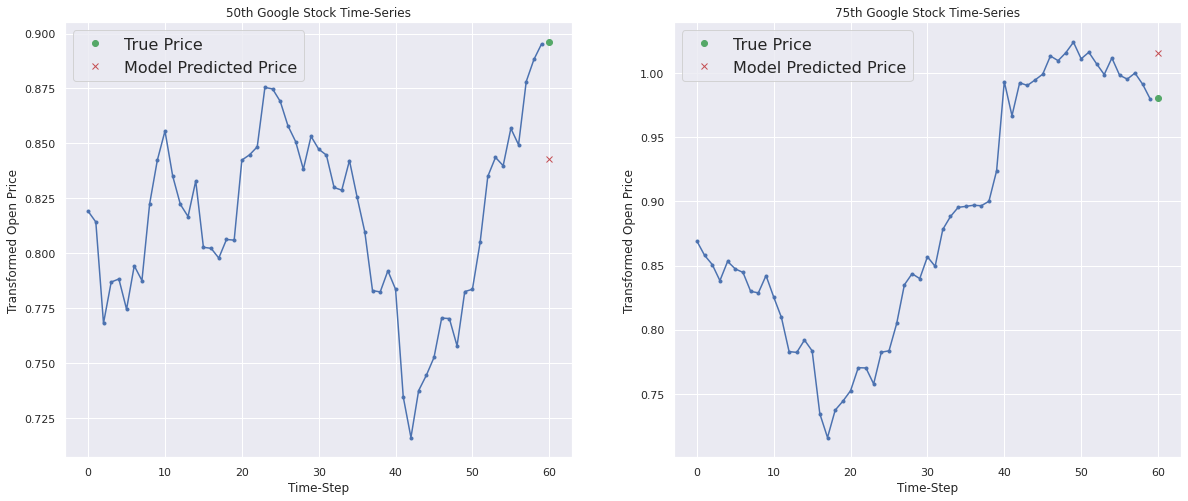

In [69]:
plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[0][:, 0], 60, mv_y_val[0], multivariate_RNN_LSTM_y_pred[0][0], "1st")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[25][:, 0], 60, mv_y_val[25], multivariate_RNN_LSTM_y_pred[25][0], "25th")

plt.figure()

plt.subplot(1, 2, 1)
plot_time_series(mv_X_val[50][:, 0], 60, mv_y_val[50], multivariate_RNN_LSTM_y_pred[50][0], "50th")
plt.subplot(1, 2, 2)
plot_time_series(mv_X_val[75][:, 0], 60, mv_y_val[75], multivariate_RNN_LSTM_y_pred[75][0], "75th")

In [70]:
print(architectures_mse)

{'Naive': 0.018099380102800208, 'FCNN': 0.002514724852517247, 'Single Neuron RNN': 0.01150713674724102, 'Deep RNN': 0.0007342133321799338, 'Deep LSTM RNN': 0.0020811338908970356, 'MV FCNN': 0.0009896964766085148, 'MV Single Neuron RNN': 0.0571771077811718, 'MV Deep RNN': 0.0020461438689380884, 'MV Deep LSTM RNN': 0.0016605647979304194}


The deep RNN with LSTM cells performs better than the simple RNN cells. This may be explained by their increased ability to retain memory. Previously, univariate analysis only contained a single feature. With 5 features in the multivariate time-series analysis, retaining memory is even more important as presumably, all features affect the "open" price.

## Conclusion

Let's first display the performances of all models.

In [71]:
pd.options.display.max_columns = 10

final_model_mse = pd.DataFrame([architectures_mse])
print(final_model_mse)

      Naive      FCNN  Single Neuron RNN  Deep RNN  Deep LSTM RNN  MV FCNN  \
0  0.018099  0.002515           0.011507  0.000734       0.002081  0.00099   

   MV Single Neuron RNN  MV Deep RNN  MV Deep LSTM RNN  
0              0.057177     0.002046          0.001661  


Based on the performance on the validations sets, the univariate Deep RNN performs the best. Let's evaluate the model's performance on the test set.

In [72]:
deep_RNN_test_mse = RNN_model.evaluate(X_test, y_test, verbose=0)
print(deep_RNN_test_mse)

0.03209763392806053


The test set mean squared error (MSE) is much worse than on the validation set. This may suggest more regularization was needed during model training. In addition, it may be more optimal to use longer time-series sequences during training to potentially help the model learn better. 

Finally, neural networks are very data demanding and the relatively small dataset used in this notebook is not ideal in training a good neural network. The code in this notebook was for personal practise in creating time-series data and applying different models for forecasting.